In [1]:
# importing the libraries
import numpy as np

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d,  Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import pickle
def load_data(in_dir):
    f = open(in_dir,'rb')
    train_data,train_label,test_data,test_label,valid_data,valid_label,pernums_valid = pickle.load(f)
    return train_data,train_label,test_data,test_label,valid_data,valid_label,pernums_valid

data_path = 'adress.pkl'
checkpoint = 'checkpoint/'

train_data,train_label,test_data,test_label,valid_data,valid_label,pernums_valid = load_data(data_path)

# converting training images into torch format
train_x = train_data
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_label
train_y = train_y.reshape(2379).astype(float);
train_y = torch.from_numpy(train_y)


# shape of training data
# train_x.shape, train_y.shape
from torch.utils.data import TensorDataset, DataLoader

# my_x = [np.array([[1.0,2],[3,4]]),np.array([[5.,6],[7,8]])] # a list of numpy arrays
# my_y = [np.array([4.]), np.array([2.])] # another list of numpy arrays (targets)

# tensor_x = torch.Tensor(my_x) # transform to torch tensor
# tensor_y = torch.Tensor(my_y)

CTX = torch.device('cuda')

train_dataset = TensorDataset(train_x.to(CTX),train_y.to(CTX)) # create your datset

 # create your dataloader


In [2]:
# converting training images into torch format
val_x = valid_data
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = valid_label
val_y = val_y.reshape(297).astype(float);
val_y = torch.from_numpy(val_y)
# shape of training data

val_dataset = TensorDataset(val_x,val_y) # create your datset

In [3]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 64
val_size = 297
# train_size = train_x.size(0) - val_size 

# train_data,val_data = random_split(dataset,[train_size,val_size])
# print(f"Length of Train Data : {len(train_data)}")
# print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 2379
#Length of Validation Data : 297

#load the train and validation into batches.
train_dl = DataLoader(train_dataset,batch_size, shuffle = True, num_workers = 0)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers = 0)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images.to(CTX))                  # Generate predictions
        loss = F.cross_entropy(out, labels.to(torch.int64).cuda()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images.to(CTX))                    # Generate predictions
        loss = F.cross_entropy(out, labels.to(torch.int64).cuda())   # Calculate loss
        acc = accuracy(out, labels.to(torch.int64).cuda())           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [5]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
#         print(x.shape())
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out
    
    
class Att_Net(ImageClassificationBase):   
    def __init__(self):
        super(Att_Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(300, 256, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(256),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(128),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=1, stride=1),
        )

        self.linear_layers = Sequential(
            Linear(128 * 20 * 1, 256),
            Linear(256, 64),
            Linear(64, 2),
        )

        self.attention = CBAM(gate_channels=128)

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.attention(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [6]:
# defining the model
model = Att_Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Att_Net(
  (cnn_layers): Sequential(
    (0): Conv2d(300, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=2560, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (attention): CBAM(
    (ChannelGate): ChannelGate(
      (mlp): Sequential(
        (0): Flatten()
        (1): Linear(in_features=128, out_features=8, bias=True)
        (2): ReLU(

In [7]:
from torchsummary import summary
summary(model, (300, 40, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 256, 40, 3]         691,456
       BatchNorm2d-2           [-1, 256, 40, 3]             512
              ReLU-3           [-1, 256, 40, 3]               0
         MaxPool2d-4           [-1, 256, 20, 1]               0
            Conv2d-5           [-1, 128, 20, 1]         295,040
       BatchNorm2d-6           [-1, 128, 20, 1]             256
              ReLU-7           [-1, 128, 20, 1]               0
         MaxPool2d-8           [-1, 128, 20, 1]               0
           Flatten-9                  [-1, 128]               0
           Linear-10                    [-1, 8]           1,032
             ReLU-11                    [-1, 8]               0
           Linear-12                  [-1, 128]           1,152
          Flatten-13                  [-1, 128]               0
           Linear-14                   

C:\Users\Asus\anaconda3\envs\tf-btp\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [9]:
# CTX = torch.device('cuda')
# train_dl.to(CTX)  #train_dataset.train_data is a Tensor(input data)
# # train_dl.train_labels.to(CTX)
# # val_dl.train_data.to(CTX)  #train_dataset.train_data is a Tensor(input data)
# # val_dl.train_labels.to(CTX)
num_epochs = 3000
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.6944, val_loss: 0.7034, val_acc: 0.4950
Epoch [1], train_loss: 0.6811, val_loss: 0.7207, val_acc: 0.5421
Epoch [2], train_loss: 0.6864, val_loss: 0.6944, val_acc: 0.5295
Epoch [3], train_loss: 0.6829, val_loss: 0.6823, val_acc: 0.5392
Epoch [4], train_loss: 0.6777, val_loss: 0.6992, val_acc: 0.5265
Epoch [5], train_loss: 0.6782, val_loss: 0.6779, val_acc: 0.5727
Epoch [6], train_loss: 0.6732, val_loss: 0.7247, val_acc: 0.5295
Epoch [7], train_loss: 0.6794, val_loss: 0.6878, val_acc: 0.5344
Epoch [8], train_loss: 0.6747, val_loss: 0.6854, val_acc: 0.5487
Epoch [9], train_loss: 0.6682, val_loss: 0.6883, val_acc: 0.5864
Epoch [10], train_loss: 0.6599, val_loss: 0.6651, val_acc: 0.5715
Epoch [11], train_loss: 0.6613, val_loss: 0.6824, val_acc: 0.5730
Epoch [12], train_loss: 0.6599, val_loss: 0.7119, val_acc: 0.5187
Epoch [13], train_loss: 0.6568, val_loss: 0.6537, val_acc: 0.5887
Epoch [14], train_loss: 0.6418, val_loss: 0.6602, val_acc: 0.5903
Epoch [15], train_lo

Epoch [124], train_loss: 0.0284, val_loss: 3.0330, val_acc: 0.5344
Epoch [125], train_loss: 0.0262, val_loss: 3.0936, val_acc: 0.5614
Epoch [126], train_loss: 0.0088, val_loss: 3.5573, val_acc: 0.5633
Epoch [127], train_loss: 0.0062, val_loss: 4.4686, val_acc: 0.5796
Epoch [128], train_loss: 0.0183, val_loss: 4.6899, val_acc: 0.5399
Epoch [129], train_loss: 0.1027, val_loss: 1.6899, val_acc: 0.5640
Epoch [130], train_loss: 0.0556, val_loss: 2.6822, val_acc: 0.5561
Epoch [131], train_loss: 0.0132, val_loss: 3.3560, val_acc: 0.5640
Epoch [132], train_loss: 0.0029, val_loss: 4.1498, val_acc: 0.5555
Epoch [133], train_loss: 0.0081, val_loss: 4.1225, val_acc: 0.5370
Epoch [134], train_loss: 0.0108, val_loss: 3.7394, val_acc: 0.5662
Epoch [135], train_loss: 0.0095, val_loss: 3.4981, val_acc: 0.5477
Epoch [136], train_loss: 0.0024, val_loss: 4.0888, val_acc: 0.5477
Epoch [137], train_loss: 0.0019, val_loss: 4.6648, val_acc: 0.5363
Epoch [138], train_loss: 0.0006, val_loss: 4.8629, val_acc: 0.

Epoch [247], train_loss: 0.0494, val_loss: 3.0806, val_acc: 0.5552
Epoch [248], train_loss: 0.0171, val_loss: 3.4722, val_acc: 0.5659
Epoch [249], train_loss: 0.0283, val_loss: 3.3559, val_acc: 0.5584
Epoch [250], train_loss: 0.0083, val_loss: 4.0756, val_acc: 0.5737
Epoch [251], train_loss: 0.0029, val_loss: 4.2670, val_acc: 0.5584
Epoch [252], train_loss: 0.0028, val_loss: 5.5073, val_acc: 0.5474
Epoch [253], train_loss: 0.0048, val_loss: 5.4105, val_acc: 0.5578
Epoch [254], train_loss: 0.0174, val_loss: 4.9483, val_acc: 0.5555
Epoch [255], train_loss: 0.0647, val_loss: 3.1113, val_acc: 0.5610
Epoch [256], train_loss: 0.0073, val_loss: 4.2376, val_acc: 0.5347
Epoch [257], train_loss: 0.0125, val_loss: 3.7730, val_acc: 0.5419
Epoch [258], train_loss: 0.0027, val_loss: 3.9793, val_acc: 0.5366
Epoch [259], train_loss: 0.0004, val_loss: 4.2098, val_acc: 0.5363
Epoch [260], train_loss: 0.0002, val_loss: 4.3379, val_acc: 0.5633
Epoch [261], train_loss: 0.0002, val_loss: 4.4821, val_acc: 0.

Epoch [370], train_loss: 0.0172, val_loss: 3.0739, val_acc: 0.5500
Epoch [371], train_loss: 0.0111, val_loss: 3.6457, val_acc: 0.5790
Epoch [372], train_loss: 0.0018, val_loss: 4.4170, val_acc: 0.5578
Epoch [373], train_loss: 0.0009, val_loss: 4.8000, val_acc: 0.5393
Epoch [374], train_loss: 0.0003, val_loss: 4.9871, val_acc: 0.5578
Epoch [375], train_loss: 0.0001, val_loss: 5.0455, val_acc: 0.5575
Epoch [376], train_loss: 0.0001, val_loss: 5.1242, val_acc: 0.5578
Epoch [377], train_loss: 0.0003, val_loss: 5.2525, val_acc: 0.5422
Epoch [378], train_loss: 0.0001, val_loss: 5.4738, val_acc: 0.5474
Epoch [379], train_loss: 0.0000, val_loss: 5.3980, val_acc: 0.5581
Epoch [380], train_loss: 0.0066, val_loss: 5.0386, val_acc: 0.5552
Epoch [381], train_loss: 0.0095, val_loss: 4.4456, val_acc: 0.5370
Epoch [382], train_loss: 0.0068, val_loss: 5.1140, val_acc: 0.5715
Epoch [383], train_loss: 0.0438, val_loss: 3.5911, val_acc: 0.5500
Epoch [384], train_loss: 0.0386, val_loss: 3.6924, val_acc: 0.

Epoch [493], train_loss: 0.0000, val_loss: 5.9678, val_acc: 0.5178
Epoch [494], train_loss: 0.0000, val_loss: 6.0489, val_acc: 0.5126
Epoch [495], train_loss: 0.0000, val_loss: 6.0548, val_acc: 0.5233
Epoch [496], train_loss: 0.0000, val_loss: 6.0513, val_acc: 0.5152
Epoch [497], train_loss: 0.0000, val_loss: 6.0953, val_acc: 0.5178
Epoch [498], train_loss: 0.0000, val_loss: 6.1112, val_acc: 0.5152
Epoch [499], train_loss: 0.0000, val_loss: 6.0676, val_acc: 0.5259
Epoch [500], train_loss: 0.0000, val_loss: 6.1364, val_acc: 0.5285
Epoch [501], train_loss: 0.0000, val_loss: 6.0506, val_acc: 0.5311
Epoch [502], train_loss: 0.0001, val_loss: 6.6680, val_acc: 0.5149
Epoch [503], train_loss: 0.0000, val_loss: 6.3959, val_acc: 0.5311
Epoch [504], train_loss: 0.0000, val_loss: 6.3513, val_acc: 0.5178
Epoch [505], train_loss: 0.0000, val_loss: 6.4338, val_acc: 0.5233
Epoch [506], train_loss: 0.0000, val_loss: 6.4280, val_acc: 0.5259
Epoch [507], train_loss: 0.0000, val_loss: 6.5313, val_acc: 0.

Epoch [616], train_loss: 0.0001, val_loss: 5.9082, val_acc: 0.5958
Epoch [617], train_loss: 0.0000, val_loss: 5.8201, val_acc: 0.5799
Epoch [618], train_loss: 0.0000, val_loss: 5.6731, val_acc: 0.5718
Epoch [619], train_loss: 0.0000, val_loss: 5.8155, val_acc: 0.5851
Epoch [620], train_loss: 0.0000, val_loss: 5.6504, val_acc: 0.5825
Epoch [621], train_loss: 0.0000, val_loss: 5.8009, val_acc: 0.5825
Epoch [622], train_loss: 0.0000, val_loss: 5.9787, val_acc: 0.5799
Epoch [623], train_loss: 0.0000, val_loss: 5.9037, val_acc: 0.5776
Epoch [624], train_loss: 0.0000, val_loss: 5.9833, val_acc: 0.5724
Epoch [625], train_loss: 0.0000, val_loss: 5.9191, val_acc: 0.5910
Epoch [626], train_loss: 0.0000, val_loss: 5.9898, val_acc: 0.5932
Epoch [627], train_loss: 0.0000, val_loss: 6.0337, val_acc: 0.5796
Epoch [628], train_loss: 0.0000, val_loss: 6.0610, val_acc: 0.5796
Epoch [629], train_loss: 0.0000, val_loss: 6.0551, val_acc: 0.5796
Epoch [630], train_loss: 0.0000, val_loss: 6.0636, val_acc: 0.

Epoch [739], train_loss: 0.0000, val_loss: 6.0287, val_acc: 0.5682
Epoch [740], train_loss: 0.0000, val_loss: 5.9170, val_acc: 0.5790
Epoch [741], train_loss: 0.0000, val_loss: 6.0280, val_acc: 0.5819
Epoch [742], train_loss: 0.0000, val_loss: 5.9830, val_acc: 0.5871
Epoch [743], train_loss: 0.0000, val_loss: 5.9915, val_acc: 0.5737
Epoch [744], train_loss: 0.0000, val_loss: 6.0449, val_acc: 0.5682
Epoch [745], train_loss: 0.0000, val_loss: 6.0116, val_acc: 0.5763
Epoch [746], train_loss: 0.0000, val_loss: 6.0407, val_acc: 0.5763
Epoch [747], train_loss: 0.0000, val_loss: 5.9093, val_acc: 0.5819
Epoch [748], train_loss: 0.0000, val_loss: 6.1191, val_acc: 0.5763
Epoch [749], train_loss: 0.0000, val_loss: 6.0442, val_acc: 0.5737
Epoch [750], train_loss: 0.0000, val_loss: 6.0801, val_acc: 0.5763
Epoch [751], train_loss: 0.0000, val_loss: 6.2174, val_acc: 0.5763
Epoch [752], train_loss: 0.0000, val_loss: 6.0175, val_acc: 0.5874
Epoch [753], train_loss: 0.0000, val_loss: 6.0193, val_acc: 0.

Epoch [862], train_loss: 0.0000, val_loss: 6.6879, val_acc: 0.5692
Epoch [863], train_loss: 0.0000, val_loss: 6.6246, val_acc: 0.5636
Epoch [864], train_loss: 0.0016, val_loss: 6.2491, val_acc: 0.5718
Epoch [865], train_loss: 0.0234, val_loss: 3.7448, val_acc: 0.5584
Epoch [866], train_loss: 0.0071, val_loss: 4.0023, val_acc: 0.5767
Epoch [867], train_loss: 0.0185, val_loss: 2.7352, val_acc: 0.5741
Epoch [868], train_loss: 0.0277, val_loss: 3.0124, val_acc: 0.6414
Epoch [869], train_loss: 0.0102, val_loss: 4.3315, val_acc: 0.5877
Epoch [870], train_loss: 0.0048, val_loss: 4.4665, val_acc: 0.6121
Epoch [871], train_loss: 0.0108, val_loss: 6.8469, val_acc: 0.5643
Epoch [872], train_loss: 0.0331, val_loss: 2.8734, val_acc: 0.5939
Epoch [873], train_loss: 0.0024, val_loss: 4.2724, val_acc: 0.5695
Epoch [874], train_loss: 0.0014, val_loss: 4.5017, val_acc: 0.5636
Epoch [875], train_loss: 0.0003, val_loss: 4.7049, val_acc: 0.5662
Epoch [876], train_loss: 0.0001, val_loss: 4.9130, val_acc: 0.

Epoch [985], train_loss: 0.0000, val_loss: 7.5315, val_acc: 0.5721
Epoch [986], train_loss: 0.0000, val_loss: 7.3468, val_acc: 0.5614
Epoch [987], train_loss: 0.0000, val_loss: 7.3919, val_acc: 0.5721
Epoch [988], train_loss: 0.0000, val_loss: 7.4170, val_acc: 0.5747
Epoch [989], train_loss: 0.0000, val_loss: 7.2409, val_acc: 0.5640
Epoch [990], train_loss: 0.0000, val_loss: 7.4757, val_acc: 0.5614
Epoch [991], train_loss: 0.0000, val_loss: 7.4827, val_acc: 0.5614
Epoch [992], train_loss: 0.0000, val_loss: 7.4904, val_acc: 0.5721
Epoch [993], train_loss: 0.0090, val_loss: 7.1388, val_acc: 0.5506
Epoch [994], train_loss: 0.0969, val_loss: 1.6974, val_acc: 0.6092
Epoch [995], train_loss: 0.0423, val_loss: 2.5834, val_acc: 0.5776
Epoch [996], train_loss: 0.0218, val_loss: 3.0171, val_acc: 0.6063
Epoch [997], train_loss: 0.0098, val_loss: 3.0883, val_acc: 0.6040
Epoch [998], train_loss: 0.0068, val_loss: 3.9612, val_acc: 0.6092
Epoch [999], train_loss: 0.0008, val_loss: 4.4010, val_acc: 0.

Epoch [1106], train_loss: 0.0042, val_loss: 4.0971, val_acc: 0.5610
Epoch [1107], train_loss: 0.0002, val_loss: 4.5113, val_acc: 0.5581
Epoch [1108], train_loss: 0.0001, val_loss: 4.5752, val_acc: 0.5581
Epoch [1109], train_loss: 0.0001, val_loss: 4.7067, val_acc: 0.5581
Epoch [1110], train_loss: 0.0001, val_loss: 4.9366, val_acc: 0.5581
Epoch [1111], train_loss: 0.0000, val_loss: 4.8753, val_acc: 0.5555
Epoch [1112], train_loss: 0.0000, val_loss: 4.9319, val_acc: 0.5529
Epoch [1113], train_loss: 0.0000, val_loss: 5.0511, val_acc: 0.5555
Epoch [1114], train_loss: 0.0000, val_loss: 5.0351, val_acc: 0.5529
Epoch [1115], train_loss: 0.0000, val_loss: 5.1253, val_acc: 0.5555
Epoch [1116], train_loss: 0.0000, val_loss: 5.1243, val_acc: 0.5503
Epoch [1117], train_loss: 0.0000, val_loss: 5.2055, val_acc: 0.5529
Epoch [1118], train_loss: 0.0000, val_loss: 5.2998, val_acc: 0.5555
Epoch [1119], train_loss: 0.0000, val_loss: 5.3215, val_acc: 0.5477
Epoch [1120], train_loss: 0.0000, val_loss: 5.30

Epoch [1227], train_loss: 0.0000, val_loss: 6.5672, val_acc: 0.5689
Epoch [1228], train_loss: 0.0000, val_loss: 6.5013, val_acc: 0.5770
Epoch [1229], train_loss: 0.0000, val_loss: 6.6117, val_acc: 0.5715
Epoch [1230], train_loss: 0.0000, val_loss: 6.6369, val_acc: 0.5689
Epoch [1231], train_loss: 0.0000, val_loss: 6.7525, val_acc: 0.5744
Epoch [1232], train_loss: 0.0000, val_loss: 6.8203, val_acc: 0.5822
Epoch [1233], train_loss: 0.0000, val_loss: 6.9040, val_acc: 0.5715
Epoch [1234], train_loss: 0.0000, val_loss: 6.9116, val_acc: 0.5770
Epoch [1235], train_loss: 0.0000, val_loss: 6.9233, val_acc: 0.5770
Epoch [1236], train_loss: 0.0000, val_loss: 6.9456, val_acc: 0.5715
Epoch [1237], train_loss: 0.0000, val_loss: 6.9862, val_acc: 0.5689
Epoch [1238], train_loss: 0.0000, val_loss: 6.7472, val_acc: 0.5770
Epoch [1239], train_loss: 0.0000, val_loss: 6.9706, val_acc: 0.5770
Epoch [1240], train_loss: 0.0000, val_loss: 6.9105, val_acc: 0.5770
Epoch [1241], train_loss: 0.0000, val_loss: 7.11

Epoch [1348], train_loss: 0.0004, val_loss: 6.1306, val_acc: 0.5932
Epoch [1349], train_loss: 0.0001, val_loss: 6.3952, val_acc: 0.5854
Epoch [1350], train_loss: 0.0001, val_loss: 6.5300, val_acc: 0.5854
Epoch [1351], train_loss: 0.0000, val_loss: 6.6910, val_acc: 0.5880
Epoch [1352], train_loss: 0.0141, val_loss: 7.1835, val_acc: 0.5666
Epoch [1353], train_loss: 0.0559, val_loss: 3.8249, val_acc: 0.5265
Epoch [1354], train_loss: 0.0065, val_loss: 5.4486, val_acc: 0.5831
Epoch [1355], train_loss: 0.0062, val_loss: 6.1205, val_acc: 0.5776
Epoch [1356], train_loss: 0.0003, val_loss: 6.3589, val_acc: 0.5776
Epoch [1357], train_loss: 0.0002, val_loss: 6.4947, val_acc: 0.5724
Epoch [1358], train_loss: 0.0001, val_loss: 6.5121, val_acc: 0.5776
Epoch [1359], train_loss: 0.0001, val_loss: 6.7005, val_acc: 0.5802
Epoch [1360], train_loss: 0.0202, val_loss: 6.7054, val_acc: 0.5617
Epoch [1361], train_loss: 0.0088, val_loss: 4.6945, val_acc: 0.5588
Epoch [1362], train_loss: 0.0014, val_loss: 5.29

Epoch [1469], train_loss: 0.0000, val_loss: 6.1381, val_acc: 0.5721
Epoch [1470], train_loss: 0.0002, val_loss: 6.1396, val_acc: 0.5750
Epoch [1471], train_loss: 0.0000, val_loss: 6.0310, val_acc: 0.5646
Epoch [1472], train_loss: 0.0000, val_loss: 6.3229, val_acc: 0.5646
Epoch [1473], train_loss: 0.0000, val_loss: 6.3591, val_acc: 0.5724
Epoch [1474], train_loss: 0.0000, val_loss: 6.2002, val_acc: 0.5698
Epoch [1475], train_loss: 0.0089, val_loss: 6.2438, val_acc: 0.5701
Epoch [1476], train_loss: 0.0108, val_loss: 5.2831, val_acc: 0.5779
Epoch [1477], train_loss: 0.0055, val_loss: 5.6407, val_acc: 0.6150
Epoch [1478], train_loss: 0.0006, val_loss: 5.5489, val_acc: 0.5910
Epoch [1479], train_loss: 0.0002, val_loss: 5.6664, val_acc: 0.5991
Epoch [1480], train_loss: 0.0002, val_loss: 5.5393, val_acc: 0.6046
Epoch [1481], train_loss: 0.0034, val_loss: 5.7132, val_acc: 0.6206
Epoch [1482], train_loss: 0.0068, val_loss: 6.2096, val_acc: 0.6040
Epoch [1483], train_loss: 0.0043, val_loss: 5.66

Epoch [1590], train_loss: 0.0000, val_loss: 6.3905, val_acc: 0.5880
Epoch [1591], train_loss: 0.0000, val_loss: 6.3817, val_acc: 0.5854
Epoch [1592], train_loss: 0.0000, val_loss: 6.4349, val_acc: 0.5880
Epoch [1593], train_loss: 0.0000, val_loss: 6.3389, val_acc: 0.5962
Epoch [1594], train_loss: 0.0000, val_loss: 6.4755, val_acc: 0.5962
Epoch [1595], train_loss: 0.0000, val_loss: 6.5605, val_acc: 0.5906
Epoch [1596], train_loss: 0.0000, val_loss: 6.4474, val_acc: 0.5962
Epoch [1597], train_loss: 0.0000, val_loss: 6.5952, val_acc: 0.5854
Epoch [1598], train_loss: 0.0000, val_loss: 6.6120, val_acc: 0.5962
Epoch [1599], train_loss: 0.0000, val_loss: 6.6432, val_acc: 0.5988
Epoch [1600], train_loss: 0.0000, val_loss: 6.8572, val_acc: 0.5962
Epoch [1601], train_loss: 0.0000, val_loss: 6.8183, val_acc: 0.5906
Epoch [1602], train_loss: 0.0000, val_loss: 6.5888, val_acc: 0.5988
Epoch [1603], train_loss: 0.0000, val_loss: 6.5579, val_acc: 0.5988
Epoch [1604], train_loss: 0.0000, val_loss: 6.87

Epoch [1711], train_loss: 0.0001, val_loss: 4.8167, val_acc: 0.6150
Epoch [1712], train_loss: 0.0001, val_loss: 4.8123, val_acc: 0.6124
Epoch [1713], train_loss: 0.0000, val_loss: 4.8706, val_acc: 0.6098
Epoch [1714], train_loss: 0.0000, val_loss: 4.8772, val_acc: 0.6098
Epoch [1715], train_loss: 0.0001, val_loss: 4.9781, val_acc: 0.6072
Epoch [1716], train_loss: 0.0000, val_loss: 5.0818, val_acc: 0.6072
Epoch [1717], train_loss: 0.0000, val_loss: 5.0640, val_acc: 0.6098
Epoch [1718], train_loss: 0.0000, val_loss: 5.1377, val_acc: 0.6098
Epoch [1719], train_loss: 0.0000, val_loss: 5.1279, val_acc: 0.6072
Epoch [1720], train_loss: 0.0000, val_loss: 4.9772, val_acc: 0.6072
Epoch [1721], train_loss: 0.0048, val_loss: 5.3591, val_acc: 0.6098
Epoch [1722], train_loss: 0.0112, val_loss: 4.4892, val_acc: 0.5906
Epoch [1723], train_loss: 0.0016, val_loss: 4.8489, val_acc: 0.5880
Epoch [1724], train_loss: 0.0022, val_loss: 4.5464, val_acc: 0.5799
Epoch [1725], train_loss: 0.0002, val_loss: 4.24

Epoch [1832], train_loss: 0.0000, val_loss: 6.0049, val_acc: 0.5874
Epoch [1833], train_loss: 0.0000, val_loss: 6.0112, val_acc: 0.6011
Epoch [1834], train_loss: 0.0000, val_loss: 5.9463, val_acc: 0.5877
Epoch [1835], train_loss: 0.0000, val_loss: 6.0078, val_acc: 0.5796
Epoch [1836], train_loss: 0.0000, val_loss: 6.0793, val_acc: 0.5903
Epoch [1837], train_loss: 0.0000, val_loss: 6.0877, val_acc: 0.5903
Epoch [1838], train_loss: 0.0000, val_loss: 6.1241, val_acc: 0.5851
Epoch [1839], train_loss: 0.0000, val_loss: 6.1709, val_acc: 0.5825
Epoch [1840], train_loss: 0.0000, val_loss: 6.0662, val_acc: 0.5929
Epoch [1841], train_loss: 0.0000, val_loss: 6.1873, val_acc: 0.5877
Epoch [1842], train_loss: 0.0000, val_loss: 6.1660, val_acc: 0.5985
Epoch [1843], train_loss: 0.0000, val_loss: 6.2699, val_acc: 0.5958
Epoch [1844], train_loss: 0.0000, val_loss: 6.2256, val_acc: 0.5929
Epoch [1845], train_loss: 0.0000, val_loss: 6.1708, val_acc: 0.5851
Epoch [1846], train_loss: 0.0000, val_loss: 6.21

Epoch [1953], train_loss: 0.0000, val_loss: 5.8364, val_acc: 0.6063
Epoch [1954], train_loss: 0.0000, val_loss: 6.1352, val_acc: 0.6033
Epoch [1955], train_loss: 0.0000, val_loss: 6.2275, val_acc: 0.6007
Epoch [1956], train_loss: 0.0000, val_loss: 6.0784, val_acc: 0.5955
Epoch [1957], train_loss: 0.0000, val_loss: 5.9176, val_acc: 0.6089
Epoch [1958], train_loss: 0.0000, val_loss: 6.3563, val_acc: 0.6007
Epoch [1959], train_loss: 0.0000, val_loss: 6.1898, val_acc: 0.6037
Epoch [1960], train_loss: 0.0000, val_loss: 6.2609, val_acc: 0.5981
Epoch [1961], train_loss: 0.0000, val_loss: 6.1663, val_acc: 0.5981
Epoch [1962], train_loss: 0.0000, val_loss: 6.2431, val_acc: 0.6007
Epoch [1963], train_loss: 0.0000, val_loss: 6.3215, val_acc: 0.5955
Epoch [1964], train_loss: 0.0000, val_loss: 6.3864, val_acc: 0.6033
Epoch [1965], train_loss: 0.0000, val_loss: 6.3450, val_acc: 0.6033
Epoch [1966], train_loss: 0.0000, val_loss: 6.3444, val_acc: 0.6011
Epoch [1967], train_loss: 0.0000, val_loss: 6.30

Epoch [2074], train_loss: 0.0000, val_loss: 6.6132, val_acc: 0.5747
Epoch [2075], train_loss: 0.0000, val_loss: 6.6972, val_acc: 0.5854
Epoch [2076], train_loss: 0.0000, val_loss: 6.9145, val_acc: 0.5880
Epoch [2077], train_loss: 0.0000, val_loss: 6.8836, val_acc: 0.5880
Epoch [2078], train_loss: 0.0000, val_loss: 6.9946, val_acc: 0.5773
Epoch [2079], train_loss: 0.0000, val_loss: 6.8324, val_acc: 0.5854
Epoch [2080], train_loss: 0.0000, val_loss: 6.9384, val_acc: 0.5854
Epoch [2081], train_loss: 0.0000, val_loss: 6.9026, val_acc: 0.5773
Epoch [2082], train_loss: 0.0000, val_loss: 7.0890, val_acc: 0.5747
Epoch [2083], train_loss: 0.0000, val_loss: 7.0948, val_acc: 0.5721
Epoch [2084], train_loss: 0.0000, val_loss: 6.9917, val_acc: 0.5747
Epoch [2085], train_loss: 0.0000, val_loss: 7.2814, val_acc: 0.5854
Epoch [2086], train_loss: 0.0000, val_loss: 7.2727, val_acc: 0.5721
Epoch [2087], train_loss: 0.0000, val_loss: 7.2039, val_acc: 0.5666
Epoch [2088], train_loss: 0.0000, val_loss: 7.34

Epoch [2195], train_loss: 0.0000, val_loss: 7.2003, val_acc: 0.5662
Epoch [2196], train_loss: 0.0000, val_loss: 7.2779, val_acc: 0.5715
Epoch [2197], train_loss: 0.0000, val_loss: 7.1878, val_acc: 0.5741
Epoch [2198], train_loss: 0.0000, val_loss: 7.1862, val_acc: 0.5662
Epoch [2199], train_loss: 0.0000, val_loss: 7.2005, val_acc: 0.5715
Epoch [2200], train_loss: 0.0000, val_loss: 7.2984, val_acc: 0.5662
Epoch [2201], train_loss: 0.0000, val_loss: 7.3323, val_acc: 0.5689
Epoch [2202], train_loss: 0.0000, val_loss: 7.2001, val_acc: 0.5715
Epoch [2203], train_loss: 0.0000, val_loss: 7.5202, val_acc: 0.5689
Epoch [2204], train_loss: 0.0000, val_loss: 7.2717, val_acc: 0.5770
Epoch [2205], train_loss: 0.0000, val_loss: 7.3654, val_acc: 0.5689
Epoch [2206], train_loss: 0.0000, val_loss: 7.2501, val_acc: 0.5689
Epoch [2207], train_loss: 0.0000, val_loss: 7.1702, val_acc: 0.5715
Epoch [2208], train_loss: 0.0000, val_loss: 7.3189, val_acc: 0.5662
Epoch [2209], train_loss: 0.0000, val_loss: 7.08

Epoch [2316], train_loss: 0.0000, val_loss: 9.7952, val_acc: 0.5503
Epoch [2317], train_loss: 0.0000, val_loss: 9.9400, val_acc: 0.5529
Epoch [2318], train_loss: 0.0000, val_loss: 9.8864, val_acc: 0.5503
Epoch [2319], train_loss: 0.0000, val_loss: 9.9861, val_acc: 0.5503
Epoch [2320], train_loss: 0.0000, val_loss: 9.9725, val_acc: 0.5610
Epoch [2321], train_loss: 0.0000, val_loss: 10.1679, val_acc: 0.5558
Epoch [2322], train_loss: 0.0000, val_loss: 10.2202, val_acc: 0.5610
Epoch [2323], train_loss: 0.0000, val_loss: 9.9192, val_acc: 0.5529
Epoch [2324], train_loss: 0.0000, val_loss: 10.2289, val_acc: 0.5503
Epoch [2325], train_loss: 0.0000, val_loss: 10.2375, val_acc: 0.5555
Epoch [2326], train_loss: 0.0000, val_loss: 9.9557, val_acc: 0.5529
Epoch [2327], train_loss: 0.0000, val_loss: 10.2271, val_acc: 0.5529
Epoch [2328], train_loss: 0.0002, val_loss: 10.3082, val_acc: 0.5503
Epoch [2329], train_loss: 0.0457, val_loss: 7.7870, val_acc: 0.5880
Epoch [2330], train_loss: 0.1361, val_loss

Epoch [2437], train_loss: 0.0000, val_loss: 7.1283, val_acc: 0.5874
Epoch [2438], train_loss: 0.0000, val_loss: 7.2915, val_acc: 0.5874
Epoch [2439], train_loss: 0.0000, val_loss: 7.2797, val_acc: 0.5848
Epoch [2440], train_loss: 0.0000, val_loss: 7.2996, val_acc: 0.5848
Epoch [2441], train_loss: 0.0000, val_loss: 7.2747, val_acc: 0.5848
Epoch [2442], train_loss: 0.0000, val_loss: 7.3487, val_acc: 0.5874
Epoch [2443], train_loss: 0.0000, val_loss: 7.1787, val_acc: 0.5848
Epoch [2444], train_loss: 0.0000, val_loss: 7.3363, val_acc: 0.5874
Epoch [2445], train_loss: 0.0000, val_loss: 7.0335, val_acc: 0.5900
Epoch [2446], train_loss: 0.0000, val_loss: 7.2272, val_acc: 0.5874
Epoch [2447], train_loss: 0.0000, val_loss: 7.2998, val_acc: 0.5822
Epoch [2448], train_loss: 0.0000, val_loss: 7.1150, val_acc: 0.5874
Epoch [2449], train_loss: 0.0000, val_loss: 7.0953, val_acc: 0.5796
Epoch [2450], train_loss: 0.0000, val_loss: 7.3120, val_acc: 0.5874
Epoch [2451], train_loss: 0.0000, val_loss: 7.37

Epoch [2558], train_loss: 0.0001, val_loss: 5.3720, val_acc: 0.5776
Epoch [2559], train_loss: 0.0000, val_loss: 5.5956, val_acc: 0.5884
Epoch [2560], train_loss: 0.0000, val_loss: 5.6967, val_acc: 0.5939
Epoch [2561], train_loss: 0.0000, val_loss: 5.4789, val_acc: 0.5884
Epoch [2562], train_loss: 0.0000, val_loss: 5.6986, val_acc: 0.5991
Epoch [2563], train_loss: 0.0000, val_loss: 5.6627, val_acc: 0.5884
Epoch [2564], train_loss: 0.0000, val_loss: 5.7666, val_acc: 0.5884
Epoch [2565], train_loss: 0.0000, val_loss: 5.6855, val_acc: 0.5939
Epoch [2566], train_loss: 0.0000, val_loss: 5.9326, val_acc: 0.5991
Epoch [2567], train_loss: 0.0000, val_loss: 5.8947, val_acc: 0.5939
Epoch [2568], train_loss: 0.0000, val_loss: 5.9925, val_acc: 0.6017
Epoch [2569], train_loss: 0.0000, val_loss: 6.0786, val_acc: 0.5939
Epoch [2570], train_loss: 0.0001, val_loss: 6.0253, val_acc: 0.5939
Epoch [2571], train_loss: 0.0000, val_loss: 6.4269, val_acc: 0.6017
Epoch [2572], train_loss: 0.0000, val_loss: 6.46

Epoch [2679], train_loss: 0.0000, val_loss: 5.5506, val_acc: 0.5646
Epoch [2680], train_loss: 0.0000, val_loss: 5.5079, val_acc: 0.5698
Epoch [2681], train_loss: 0.0000, val_loss: 5.6312, val_acc: 0.5776
Epoch [2682], train_loss: 0.0000, val_loss: 5.7658, val_acc: 0.5698
Epoch [2683], train_loss: 0.0000, val_loss: 5.7224, val_acc: 0.5750
Epoch [2684], train_loss: 0.0000, val_loss: 5.7852, val_acc: 0.5724
Epoch [2685], train_loss: 0.0000, val_loss: 5.6281, val_acc: 0.5724
Epoch [2686], train_loss: 0.0000, val_loss: 5.6532, val_acc: 0.5698
Epoch [2687], train_loss: 0.0000, val_loss: 5.6654, val_acc: 0.5750
Epoch [2688], train_loss: 0.0000, val_loss: 5.8214, val_acc: 0.5776
Epoch [2689], train_loss: 0.0000, val_loss: 5.8122, val_acc: 0.5750
Epoch [2690], train_loss: 0.0000, val_loss: 5.8676, val_acc: 0.5776
Epoch [2691], train_loss: 0.0000, val_loss: 5.8782, val_acc: 0.5750
Epoch [2692], train_loss: 0.0000, val_loss: 5.7850, val_acc: 0.5802
Epoch [2693], train_loss: 0.0000, val_loss: 5.85

Epoch [2800], train_loss: 0.0000, val_loss: 8.6902, val_acc: 0.5568
Epoch [2801], train_loss: 0.0000, val_loss: 8.8097, val_acc: 0.5620
Epoch [2802], train_loss: 0.0000, val_loss: 8.7349, val_acc: 0.5646
Epoch [2803], train_loss: 0.0000, val_loss: 8.7125, val_acc: 0.5646
Epoch [2804], train_loss: 0.0000, val_loss: 8.8006, val_acc: 0.5672
Epoch [2805], train_loss: 0.0000, val_loss: 8.9158, val_acc: 0.5594
Epoch [2806], train_loss: 0.0000, val_loss: 8.9040, val_acc: 0.5672
Epoch [2807], train_loss: 0.0000, val_loss: 8.7133, val_acc: 0.5620
Epoch [2808], train_loss: 0.0000, val_loss: 8.6648, val_acc: 0.5646
Epoch [2809], train_loss: 0.0000, val_loss: 8.6950, val_acc: 0.5542
Epoch [2810], train_loss: 0.0000, val_loss: 8.6903, val_acc: 0.5646
Epoch [2811], train_loss: 0.0000, val_loss: 8.7451, val_acc: 0.5620
Epoch [2812], train_loss: 0.0045, val_loss: 8.5877, val_acc: 0.5643
Epoch [2813], train_loss: 0.0319, val_loss: 3.3087, val_acc: 0.6394
Epoch [2814], train_loss: 0.0187, val_loss: 4.51

Epoch [2921], train_loss: 0.0001, val_loss: 5.4966, val_acc: 0.6095
Epoch [2922], train_loss: 0.0001, val_loss: 5.6666, val_acc: 0.6095
Epoch [2923], train_loss: 0.0000, val_loss: 5.6954, val_acc: 0.6043
Epoch [2924], train_loss: 0.0000, val_loss: 5.8926, val_acc: 0.6043
Epoch [2925], train_loss: 0.0000, val_loss: 5.9131, val_acc: 0.6069
Epoch [2926], train_loss: 0.0000, val_loss: 6.1082, val_acc: 0.5991
Epoch [2927], train_loss: 0.0000, val_loss: 6.0582, val_acc: 0.6043
Epoch [2928], train_loss: 0.0001, val_loss: 6.2401, val_acc: 0.6043
Epoch [2929], train_loss: 0.0000, val_loss: 6.3444, val_acc: 0.6040
Epoch [2930], train_loss: 0.0000, val_loss: 6.4158, val_acc: 0.5936
Epoch [2931], train_loss: 0.0000, val_loss: 6.3873, val_acc: 0.5910
Epoch [2932], train_loss: 0.0000, val_loss: 6.4576, val_acc: 0.5991
Epoch [2933], train_loss: 0.0001, val_loss: 6.6170, val_acc: 0.5936
Epoch [2934], train_loss: 0.0000, val_loss: 6.6604, val_acc: 0.5991
Epoch [2935], train_loss: 0.0000, val_loss: 6.70

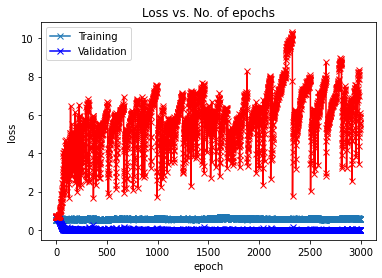

In [10]:
import matplotlib.pyplot as plt

def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [11]:
max([x['val_acc'] for x in history])

0.6602515578269958